# Converting TensorFlow Model

## Overview

MLI Library v.1.1 introduces a new way of model deployment for target applications. MLI support has been integrated into Tensorflow Lite Micro framework which means that it's tools are now available to MLI users as well. So, alternatively to manual graph mapping you can use TFLM converting capabilities to convert model to MLI compatible formal.

In this tutorial we'll cover Tensorflow model convertion specific for ARC target application. It implies that all model values (weights and activations) and preferably inputs and outputs should be converted to 8-bit integers.

Since full integer quantization (the one that includes inputs and outputs) is supported in Tensorflow 2 staring from version 2.3 it is important that your setup provides this version or newer. Please, make sure that this and other requirements from *requirements.txt* are satisfied and let's begin!

In [10]:
import tensorflow.compat.v2 as tf
from tensorflow import keras
    
print(tf.__version__)
assert tf.__version__ >= '2.3'

2.3.0-dev20200609


## Model definition

We are going to use a letter recognition model that was trained on EMNIST Letters dataset. Training of this model is described in details in [tutorial_emnist_tensorflow], which covers manual mapping. In this tutorial we're just going to define model and load pretrained weights(*mli_cnn_bn.h5*).

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.layers import Activation, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential

img_rows = 28
img_cols = 28
num_classes = 26
input_shape = (img_rows, img_cols, 1)
filter_x = 5
filter_y = 5

model = Sequential()

#Conv1
model.add(Conv2D(filters=16, 
                 kernel_size=(filter_x, filter_y), 
                 padding="same",  
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

#Conv2
model.add(Conv2D(filters=32, 
                 kernel_size=(filter_x, filter_y), 
                 padding="same", 
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

#Conv3
model.add(Conv2D(filters=32, 
                 kernel_size=(filter_x, filter_y), 
                 padding="same", 
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

#FC1
model.add(Flatten())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation("relu"))

#FC2
model.add(Dense(num_classes))
model.add(Activation("softmax"))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.load_weights('mli_cnn_bn.h5')

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 14, 14, 32)       

## Load and preprocess images

Even though we're using pretrained model we still need images from EMNIST dataset for following convertion purposes:
1. TFLiteConverter requires a representative dataset of input pictures to perform integer quantization
2. Pictures will be used for converted model testing and evaluation

Load letters test samples from EMNIST dataset:

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from emnist import extract_test_samples

test_images, test_labels = extract_test_samples('letters')

# Make class numbering start at 0
test_labels = test_labels - 1

### Preprocessing

Model expects preprocessed images as inputs, so dataset images should undergo following preprocessing steps: 
1. Reshape (28,28) bitmaps as (28,28,1)
2. Perform thinning: set values to either 0 or 255
3. Normalize values, so the range becomes [-1.0, 1.0]

In [13]:
preprocessed_test_images = test_images.reshape([test_images.shape[0], img_rows, img_cols, 1])

def thinning(image):
    tmp = np.where(image < 210.0, 0, image)
    return np.where(tmp > 210.0, 255, tmp)

preprocessed_test_images = thinning(preprocessed_test_images)

preprocessed_test_images = (preprocessed_test_images - 128.0) / 128.0

## Convert model into TFLM format

Now that we have the model and EMNIST samples we can convert model using [TFLiteConverter]. 

Setup TFLiteConverter to load the model and perform full integer quantization:

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

Provide a representative dataset:

In [15]:
preprocessed_test_images = tf.cast(preprocessed_test_images, tf.float32)
emnist_ds = tf.data.Dataset.from_tensor_slices((preprocessed_test_images)).batch(1)

def representative_data_gen():
    for input_value in emnist_ds.take(100):
        yield [input_value]
    
converter.representative_dataset = representative_data_gen

Convert the model to TensorFlow Lite format and save it to a file:

In [16]:
import pathlib

converted_model = converter.convert()

generated_dir = pathlib.Path("generated/")
generated_dir.mkdir(exist_ok=True, parents=True)
converted_model_file = generated_dir/"emnist_model_int8.tflite"
converted_model_file.write_bytes(converted_model)

INFO:tensorflow:Assets written to: C:\Users\DARIA~1.SYN\AppData\Local\Temp\tmpc7ktpw1j\assets


INFO:tensorflow:Assets written to: C:\Users\DARIA~1.SYN\AppData\Local\Temp\tmpc7ktpw1j\assets


67824

In order to integrate converted model into TFLM application we have to save it as a C array. One way to do that is to use **xxd** utility available on Linux or in Cygwin\Mingw terminals on Windows. Open terminal and run following commands:

```
cd generated/
xxd -i emnist_model_int8.tflite > model.h
```

The model can now be integrated into TFLM application.

## Evaluate model

To ensure that convertion went well let's run the model on a test dataset and check that accuracy is around 90%.

In [17]:
interpreter = tf.lite.Interpreter(model_path=str(converted_model_file))
interpreter.allocate_tensors()

In [18]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    scale, zero_point = interpreter.get_output_details()[0]['quantization']

    prediction_values = []
    
    for test_image in preprocessed_test_images:
        # Pre-processing: add batch dimension, quantize and convert inputs to int8 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0) #.astype(np.float32)
        test_image = np.int8(test_image / scale + zero_point)
        interpreter.set_tensor(input_index, test_image)

        interpreter.invoke()

        # Find the letter with highest probability
        output = interpreter.tensor(output_index)
        result = np.argmax(output()[0])
        prediction_values.append(result)
    
    accurate_count = 0
    for index in range(len(prediction_values)):
        if prediction_values[index] == test_labels[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_values)

    return accuracy * 100

Please, keep in mind that full test dataset evaluation on int8 model may take several minutes. 

In [19]:
print(str(evaluate_model(interpreter)) + "%")

91.6875%


## Create a test set for target application

In order to test model in a target application we're going to generate a C file containing test samples gathered from EMNIST database. 
In our case samples are going to be random:

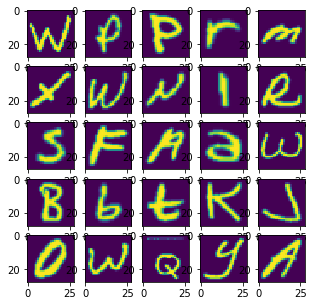

In [8]:
import random

num_of_samples = 25
random_test_images = random.sample(range(1, test_images.shape[0]), num_of_samples)

fig=plt.figure(figsize=(5, 5))
cols = 5
rows = 5

for plt_idx, img_idx in enumerate(random_test_images, 1):
    img = test_images[img_idx]
    fig.add_subplot(rows, cols, plt_idx)
    plt.imshow(img)
plt.show()

Write samples to *test_samples.cc* file:

In [9]:
from matplotlib.cbook import flatten

samples_file = open("generated/test_samples.cc", "w")

samples_file.write("#include \"test_samples.h\"\n\n")
samples_file.write("const int kNumSamples = " + str(num_of_samples) + ";\n\n")

samples = "" 
samples_array = "const TestSample test_samples[kNumSamples] = {"

for sample_idx, img_idx in enumerate(random_test_images, 1):
    img = test_images[img_idx]
    var_name = "sample" + str(sample_idx)
    samples += "TestSample " + var_name + " = {\n" #+ "[IMAGE_SIZE] = { "
    samples += "\t.image = " + str(list(flatten(img))) + ",\n"
    samples += "\t.label = " + str(test_labels[img_idx]) + ",\n};\n\n" 
    samples_array += var_name + ", "
    
samples = samples.replace("[", "{")
samples = samples.replace("]", "}")
samples_array+="};\n"

samples_file.write(samples);
samples_file.write(samples_array);
samples_file.close()

## Done

You have converted a Tensorflow model into TFLM format and generated a test set for the application. Now you can copy generated files into target application of this tutorial - **emnist_example_tflm**, and try it out:
* copy *generated/model.h* and *generated/test_samples.cc* to *../example_emnist_tflm*
* open *../example_emnist_tflm* in terminal and build and run application:
```
make
make run
```